In [1]:
import importlib
import os
import time
from collections import OrderedDict
import numpy as np
import pandas as pd
from datetime import datetime
import missingno as msno
import plotly.express as px
import squarify
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandas.plotting import register_matplotlib_converters
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
from IPython.display import display, Markdown, clear_output, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive
from qgrid import show_grid
import textwrap as tw
import datetime

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import seasonal
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from scipy import signal
import pmdarima as pm

from pandas.plotting import lag_plot
from pylab import rcParams

from sklearn.metrics import r2_score, mean_absolute_error

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
pd.options.display.float_format = '{:,.4f}'.format

In [2]:
# import function
import src
import src.analysis
importlib.reload(src.analysis)
from src.analysis import Analysis

from src.Config import Config

In [3]:
display(Markdown('<a id="top"></a>'))
sections = ["BIODIESEL_B10", "PRIMAX_95"]

sub_sections = ["Data Summary", "Missing Analysis", "Time Series Feature Analysis", "Modelling Analysis"]
    
accordions = OrderedDict()
accordions["-= Loading =-"] = widgets.Accordion(children=[widgets.Output() for section in sections])
[accordions["-= Loading =-"].set_title(i, section) for i, section in enumerate(sections)]

for section in sections:
    accordions[section] = widgets.Accordion(children=[widgets.Output() for sub_section in sub_sections])
    [accordions[section].set_title(i, sub_section) for i, sub_section in enumerate(sub_sections)]

tab_fields = widgets.Tab(children=[accordions[v] for v in accordions])
[tab_fields.set_title(i, s) for i, s in enumerate(accordions.keys())];

<a id="top"></a>

In [4]:
tab_fields

In [5]:
analysis = Analysis()

In [6]:
%matplotlib agg
section = 'BIODIESEL_B10'

with accordions["-= Loading =-"].children[sections.index(section)]:
    clear_output()
    analysis.get_biodiesel()
    
#
# Data Summary
#
with accordions[section].children[0]:
    clear_output()
    
    display(Markdown(r'<h2> BioDiesel B10 Data Summary </h2>'))
    display(Markdown(r'<h3> 1. Overview from All Stations in BioDiesel B10 </h3>'))
    display(analysis.grid_df_display([analysis.descriptive_data(analysis.data['biodiesel_df']), analysis.data_type_analysis(analysis.data['biodiesel_df'])]))
    
    for district, data in analysis.data['biodiesel_df'].groupby('District'):
        display(Markdown(r'<h4> Sales For Each Month in <code>{}</code> </h4>'.format(district)))
        display(analysis.weekday_weekend(data, 'Month_Int', 'Prod_Sales'))
    
    for district in analysis.unique_sorted_values_plus_ALL(analysis.data['biodiesel_df']['District']):
        if district != 'ALL':
            display(Markdown(r'<h2> {} </h2>'.format(district)))
            for col in analysis.data['biodiesel_df'][analysis.data['biodiesel_df']['District'] == district][analysis.vars(['Biodiesel_50'])].columns:
                if round(analysis.data['biodiesel_df'][analysis.data['biodiesel_df']['District'] == district][col].isnull().sum() / analysis.data['biodiesel_df'][analysis.data['biodiesel_df']['District'] == district].shape[0], 2) == 1:
                    pass
                else:   
                    display(Markdown(r'<h4> {} </h4>'.format(col)))
                    display(analysis.distribution_plot_summary(analysis.data['biodiesel_df'][analysis.data['biodiesel_df']['District'] == district], col, 'Prod_Sales'))   
            
    display(Markdown('[Home](#top)'))
    
#
# Missing Analysis
#
with accordions[section].children[1]:
    clear_output()
    
    display(Markdown(r'<h3> 1. Value Available Across All Variables </h3>'))
    display(analysis.missingno_barchart(analysis.data['biodiesel_df'], [v for v in analysis.vars(['Biodiesel_50']) if v in analysis.data['biodiesel_df'].columns]))

    display(Markdown(r'<h3> {}. {} </h3>'.format(2, "Input Variables Acquired Across Time in All District")))
    analysis.data['biodiesel_df'][[v for v in analysis.vars(['Biodiesel_50']) if v in analysis.data['biodiesel_df'].columns]].index = pd.to_datetime(analysis.data['biodiesel_df'][[v for v in analysis.vars(['Biodiesel_50']) if v in analysis.data['biodiesel_df'].columns]].index, errors='coerce')
    display(analysis.missingno_matrix(analysis.data['biodiesel_df'][[v for v in analysis.vars(['Biodiesel_50']) if v in analysis.data['biodiesel_df'].columns]], 14, 'W'))

    display(Markdown(r'<h3> {}. {} </h3>'.format(3, "Overview on Missing Pattern in <code>Biodisel B10</code> Data")))
    for district, data in analysis.data['missing_pect_biodiesel_50'].groupby('District'):
        display(analysis.heatmap_plot(data, district, rotate='vertical'))
        
    display(Markdown('[Home](#top)'))
        
#
# Time series analysis
#
with accordions[section].children[2]:
    clear_output()
    
    display(Markdown(r'<h3> Biodiesel Product Sales Across Time with Train-Test Split at: {} </h3>'.format(Config.MODELLING_CONFIG['METRIC_BEST_THRESH'])))
    for district, data in analysis.data['biodiesel_df'].groupby('District'):
        display(Markdown(r'<h4> <code>{}</code> </h4>'.format(district)))
        display(analysis.timeseries_plot(data.reset_index(), 'Date', 'Prod_Sales', datetime.date(2020,3,17), 'Biodiesel Sales at {}'.format(district)))
    
    display(Markdown(r'<h3> Technical Features Extracted on Time Series Domain </h3>'))
    for district, data in analysis.data['biodiesel_df'].groupby('District'):
        display(Markdown(r'<h4> <code>{}</code> </h4>'.format(district)))
        display(analysis.plot_technical_indicators(data, 'Prod_Sales', data.shape[0]))
        display(analysis.histogram_probability_plot(data, 'Prod_Sales', 50, district))
        
    display(Markdown(r'<h3> Technical Features Extracted on Frequency Domain </h3>'))
    for district, data in analysis.data['biodiesel_df'].groupby('District'):
        display(Markdown(r'<h4> <code>{}</code> </h4>'.format(district)))
        display(analysis.frequency_plot(data, 'Prod_Sales', district))
        
    display(Markdown('[Home](#top)'))
        
#
# Modelling Analysis
#
with accordions[section].children[3]:
    clear_output()
    
    display(Markdown(r'<h3> Modelling Analysis on Component of Time Series Data </h3>'))
    for district, data in analysis.data['biodiesel_df'].groupby('District'):
        display(Markdown(r'<h4> Component of Biodiesel Sales at <code>{}</code> </h4>'.format(district)))
        display(analysis.component_plot(data, 'Prod_Sales'))
        display(analysis.test_stationarity(data, 'Prod_Sales'))
        
    display(Markdown(r'<h3> Autocorrelation Plot Analysis </h3>'))
    for district, data in analysis.data['biodiesel_df'].groupby('District'):
        display(Markdown(r'<h4> Number of Lags Dependency Analysis at <code>{}</code> </h4>'.format(district)))
        display(analysis.scatter_lag_plots(data, 8, 'Prod_Sales', district))
        display(analysis.autocorrelation_plot(data, 'Prod_Sales'))
        display(analysis.partial_autocorrelation_plot(data, 'Prod_Sales'))
        
    display(Markdown('[Home](#top)'))

In [7]:
%matplotlib agg
section = 'PRIMAX_95'

with accordions["-= Loading =-"].children[sections.index(section)]:
    clear_output()
    analysis.get_primax95()
    
#
# Data Summary
#
with accordions[section].children[0]:
    clear_output()
    
    display(Markdown(r'<h2> BioDiesel B10 Data Summary </h2>'))
    display(Markdown(r'<h3> 1. Overview from All Stations in BioDiesel B10 </h3>'))
    display(analysis.grid_df_display([analysis.descriptive_data(analysis.data['primax_95_df']), analysis.data_type_analysis(analysis.data['primax_95_df'])]))
    
    for district, data in analysis.data['primax_95_df'].groupby('District'):
        display(Markdown(r'<h4> Sales For Each Month in <code>{}</code> </h4>'.format(district)))
        display(analysis.weekday_weekend(data, 'Month_Int', 'Prod_Sales'))
    
    for district in analysis.unique_sorted_values_plus_ALL(analysis.data['primax_95_df']['District']):
        if district != 'ALL':
            display(Markdown(r'<h2> {} </h2>'.format(district)))
            for col in analysis.data['primax_95_df'][analysis.data['primax_95_df']['District'] == district][analysis.vars(['Primax_95'])].columns:
                if round(analysis.data['primax_95_df'][analysis.data['primax_95_df']['District'] == district][col].isnull().sum() / analysis.data['primax_95_df'][analysis.data['primax_95_df']['District'] == district].shape[0], 2) == 1:
                    pass
                else:   
                    display(Markdown(r'<h4> {} </h4>'.format(col)))
                    display(analysis.distribution_plot_summary(analysis.data['primax_95_df'][analysis.data['primax_95_df']['District'] == district], col, 'Prod_Sales'))   
    
    display(Markdown('[Home](#top)'))
    
#
# Missing Analysis
#
with accordions[section].children[1]:
    clear_output()
    
    display(Markdown(r'<h3> 1. Value Available Across All Variables </h3>'))
    display(analysis.missingno_barchart(analysis.data['primax_95_df'], [v for v in analysis.vars(['Primax_95']) if v in analysis.data['primax_95_df'].columns]))

    display(Markdown(r'<h3> {}. {} </h3>'.format(2, "Input Variables Acquired Across Time in All District")))
    analysis.data['biodiesel_df'][[v for v in analysis.vars(['Biodiesel_50']) if v in analysis.data['primax_95_df'].columns]].index = pd.to_datetime(analysis.data['primax_95_df'][[v for v in analysis.vars(['Primax_95']) if v in analysis.data['biodiesel_df'].columns]].index, errors='coerce')
    display(analysis.missingno_matrix(analysis.data['primax_95_df'][[v for v in analysis.vars(['Primax_95']) if v in analysis.data['primax_95_df'].columns]], 14, 'W'))

    display(Markdown(r'<h3> {}. {} </h3>'.format(3, "Overview on Missing Pattern in <code>Primax 95</code> Data")))
    for district, data in analysis.data['missing_pect_primax_95'].groupby('District'):
        display(analysis.heatmap_plot(data, district, rotate='vertical'))
        
    display(Markdown('[Home](#top)'))
        
#
# Time series analysis
#
with accordions[section].children[2]:
    clear_output()
    
    display(Markdown(r'<h3> Biodiesel Product Sales Across Time with Train-Test Split at: {} </h3>'.format(Config.MODELLING_CONFIG['METRIC_BEST_THRESH'])))
    for district, data in analysis.data['primax_95_df'].groupby('District'):
        display(Markdown(r'<h4> <code>{}</code> </h4>'.format(district)))
        display(analysis.timeseries_plot(data.reset_index(), 'Date', 'Prod_Sales', datetime.date(2020,3,17), 'Primax Sales at {}'.format(district)))
    
    display(Markdown(r'<h3> Technical Features Extracted on Time Series Domain </h3>'))
    for district, data in analysis.data['primax_95_df'].groupby('District'):
        display(Markdown(r'<h4> {} </h4>'.format(district)))
        display(analysis.plot_technical_indicators(data, 'Prod_Sales', data.shape[0]))
        display(analysis.histogram_probability_plot(data, 'Prod_Sales', 50, district))
        
    display(Markdown(r'<h3> Technical Features Extracted on Frequency Domain </h3>'))
    for district, data in analysis.data['primax_95_df'].groupby('District'):
        display(Markdown(r'<h4> <code>{}</code> </h4>'.format(district)))
        display(analysis.frequency_plot(data, 'Prod_Sales', district))
        
    display(Markdown('[Home](#top)'))
        
#
# Modelling Analysis
#
with accordions[section].children[3]:
    clear_output()
    
    display(Markdown(r'<h3> Modelling Analysis on Component of Time Series Data </h3>'))
    for district, data in analysis.data['primax_95_df'].groupby('District'):
        display(Markdown(r'<h4> Component of Primax Sales at <code>{}</code> </h4>'.format(district)))
        display(analysis.component_plot(data, 'Prod_Sales'))
        display(analysis.test_stationarity(data, 'Prod_Sales'))
        
    display(Markdown(r'<h3> Autocorrelation Plot Analysis </h3>'))
    for district, data in analysis.data['primax_95_df'].groupby('District'):
        display(analysis.scatter_lag_plots(data, 8, 'Prod_Sales', district))
        display(analysis.autocorrelation_plot(data, 'Prod_Sales'))
        display(analysis.partial_autocorrelation_plot(data, 'Prod_Sales'))
        
    display(Markdown('[Home](#top)'))

# Testing

In [8]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

from warnings import catch_warnings
from warnings import filterwarnings

%matplotlib inline

In [9]:
def difference(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

def inverse_difference(history, y_hat, interval=1):
    return y_hat + history[-interval]

def split_dataset(data, n_test):
    train, test = data[0: n_test], series[n_test: len(data)]
    train = np.array(np.array_split(train, round(len(train)/7)))
    test = np.array(np.array_split(test, round(len(test)/7)))
    return train, test

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def to_series(data):
    series = np.concatenate((np.array(data).flatten()), axis=0)
    return series

def evaluate_forecasts(actual, predicted):
    scores = list()
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        rmse = sqrt(mse)
        scores.append(rmse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(len(actual)):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

def evaluate_model(model_func, train, test, orders):
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        y_hat_seq = model_func(history, orders)
        predictions.append(y_hat_seq)
        history.append(test[i])
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test, predictions)
    return score, scores, predictions

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: Total RMSE --> [%.3f]; Daily RMSE: %s' % (name, score, s_scores))

def arima_forecast(history, arima_order):
    series = to_series(history)
    model = ARIMA(series, order=arima_order)
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

def Sarima_forecast(history, config):
    order, sorder, trend = config
    series = to_series(history)
    model = SARIMAX(series, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

def evaluate_algorithms(models, orders, train, test):
    prediction_simulations = list()
    for (name, func), order in zip(models.items(), orders):
        score, scores, predictions = evaluate_model(func, train, test, order)
        summarize_scores(name, score, scores)
        prediction_simulations.append(predictions)
    return prediction_simulations

def daily_errors_plot(x_var, y_var, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    _ = plt.plot(x_var, y_var, marker='o', label=title)
    _ = plt.ylabel('RMSE', fontsize=10)
    _ = plt.ylabel('Days', fontsize=10)
    _ = plt.title(title, fontsize=12, weight="bold")
    _ = plt.legend()
    _ = plt.show()
    
    return _

def arima_orders(p_values, d_values, q_values):
    orders = list()
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                orders.append(order)
    return orders

def Sarima_configs(seasonal=[0]):
    configs = list()
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    configs.append(cfg)
    return configs

In [10]:
model_df = analysis.data['biodiesel_df'].loc[analysis.data['biodiesel_df']['District']=="Sitiawan"]
model_df = model_df[['Prod_Sales']]

result = adfuller(model_df['Prod_Sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
# if result[1] > 0.05:
#     print("Time series is not stationary, applied differencing ...")
#     series = difference(model_df['Prod_Sales'])
# elif result[1] < 0.05:
#     print("Time series is stationary, no differencing is required!")
#     series = model_df['Prod_Sales']
# else:
#     print("P-value is not valid ...")
#     pass

series = model_df['Prod_Sales'].values
train_size = int(len(series) * 0.8)

def split_dataset(data, y_var, data_series, n_test):
    train, test = data[y_var][0: n_test], data[y_var][n_test: len(data)]
    
    test_series, test_series = data_series[0: n_test], data_series[n_test: len(data_series)]
    train_series = np.array(np.array_split(train, round(len(train)/7)))
    test_series = np.array(np.array_split(test, round(len(test)/7)))
    return train, test, train_series, test_series

train, test, train_series, test_series = split_dataset(model_df, "Prod_Sales", series, train_size)

ADF Statistic: -0.635510
p-value: 0.862755
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579


In [11]:
N_TEST = round(model_df.shape[0] * 0.60)

orders = list()
arima_order = (1,0,0)
orders.extend([arima_order])

models = dict()
models['arima'] = arima_forecast
colors = list()
colors.extend(['red','blue'])

days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

In [12]:
score, scores, predictions = evaluate_model(model_func=arima_forecast, train=train_series, test=test_series, orders=arima_order)
prediction_simulations = evaluate_algorithms(models, orders, train=train_series, test=test_series)

arima: Total RMSE --> [2059.010]; Daily RMSE: 1499.9, 2568.2, 3281.6, 3172.2, 4178.0, 5216.3, 4388.0


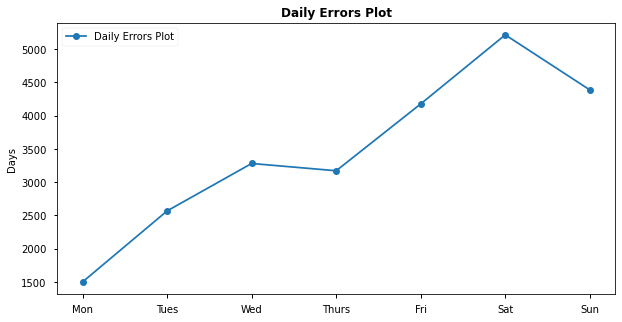

In [13]:
daily_errors_plot(days, scores, "Daily Errors Plot")

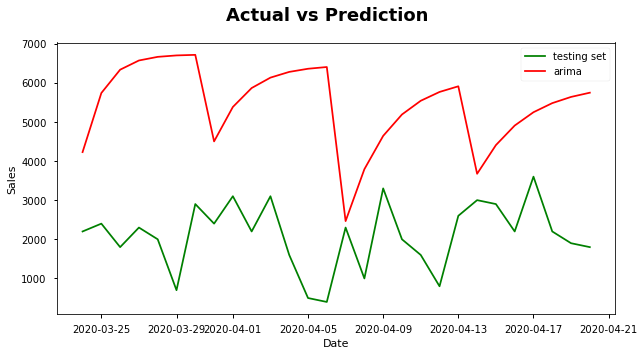

<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [14]:
def plot_forecasts(models, train, test, prediction_simulations, colors, n_test, ylabel, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(test.index, test.values, color = 'green', label="testing set")
    for i, (name, model), color in zip(range(len(prediction_simulations)), models.items(), colors):
        prediction_value = np.array(prediction_simulations[i]).flatten()
        predictions = pd.Series(prediction_value, index=test.index)
        plt.plot(predictions.index, predictions.values, color=color, label=name)

    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.suptitle(title, fontsize=18, fontweight='bold')
    plt.legend()
    plt.show()
    
    return plt

plot_forecasts(models, train, test, prediction_simulations, colors, N_TEST, "Sales", "Actual vs Prediction")

In [15]:
p_values = range(0, 8)
d_values = range(0, 3)
q_values = range(0, 2)

orders_arima_list = arima_orders(p_values, d_values, q_values)

In [16]:
args = list()
args.extend([orders_arima_list])

In [17]:
def evaluate_model(model_func, train, test, orders):
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        y_hat_seq = model_func(history, orders)
        predictions.append(y_hat_seq)
        history.append(test[i])
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test, predictions)
    return score, scores, predictions

In [18]:
score, scores, predictions = evaluate_model(model_func=arima_forecast, train=train_series, test=test_series, orders=arima_order)
print(score)

2059.009724119694


In [19]:
def evaluate_arima_scores(model_func, model_name, train, test, orders, debug=False):
    # score = None
    if debug:
        score, scores, predictions = evaluate_model(model_func, train, test, orders)
    else:
        try:
            with catch_warnings():
                filterwarnings("ignore")
                score, scores, predictions = evaluate_model(model_func, train, test, orders)
        except:
            score = None
    if score is not None:
        print(model_name + '%s RMSE=%.3f' % (orders, score))
    return (orders, score)

In [20]:
orders_list = orders_arima_list
model_func = models.values()
model_name = models.keys()

In [21]:
for (model, func), arg in zip(models.items(), args):
    scores = None
    scores = [evaluate_arima_scores(func, model, train, test, order) for order in orders_list]
    scores = [r for r in scores if r[1] != None]
    print(scores)

[]


In [ ]:
def grid_search_arima(model_func, model_name, train, test, orders_list):
    scores = None
    scores = [evaluate_arima_scores(model_func, model_name, train, test, order) for order in orders_list]

    scores = [r for r in scores if r[1] != None]
    

In [ ]:
# grid search configs for ARIMA model
def grid_search_arima_family(func, name, train, test, orders_list, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(evaluate_arima_family_scores)(func, name, train, test, order) for order in orders_list)
        scores = executor(tasks)
    else:
        scores = [evaluate_arima_family_scores(func, name, train, test, order) for order in orders_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores, name

In [481]:
residuals_model = dict() 

def plot_residuals(models, test, prediction_simulations, colors, n_test):
    test = np.reshape(test, (test.shape[0]*test.shape[1], test.shape[2]))
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8,8))
    
    for i, (name, model), color in zip(range(len(prediction_simulations)), models.items(), colors):
        predictions = np.array(prediction_simulations[i]).flatten()
        residuals = [test[i,0] - predictions[i] for i in range(len(test))]
        residuals = pd.DataFrame(residuals)
        residuals.plot(kind = 'line', ax = ax1, color=color)
        residuals.hist(ax = ax2, bins = 30, color=color)
        residuals.plot(kind = 'kde', ax = ax3, color=color)
        
        residuals_model[name] = residuals
        
    ax1.set_ylabel('Residual value ($)')
    ax1.set_xlabel('Time (days)')
    ax2.set_ylabel('Counts')
    plt.xlabel('Price ($)')
    ax1.legend(['arima','Sarima'])
    ax2.legend(['arima','Sarima'])
    ax3.legend(['arima','Sarima'])
    fig.suptitle(r'Evolution of the residuals', fontsize=18, fontweight='bold', y=0.92)
    plt.show()

In [31]:
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  109
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -999.108
Method:                       css-mle   S.D. of innovations           2299.191
Date:                Sun, 09 Aug 2020   AIC                           2012.216
Time:                        01:35:19   BIC                           2031.055
Sample:                             1   HQIC                          2019.856
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2300     58.141     -0.038      0.969    -116.184     111.724
ar.L1.D.y     -1.0799      0.096    -11.280      0.000      -1.268      -0.892
ar.L2.D.y     -0.8993      0.140     -6.431      0.0

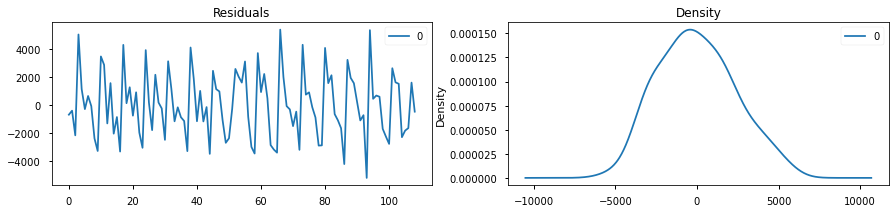

In [33]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [53]:
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit(disp=0)
    
    y_hat = model_fit.forecast()[0]
    y_hat = inverse_difference(history, y_hat)
    predictions.append(y_hat)
    obs = test[i]
    history.append(obs)
    
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 1650.687


In [16]:
predictions = list()

for t in range(len(test)):
    model = ARIMA(train, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_values[t]
#     train.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=2511.285810, expected=2200.000000
predicted=2511.285810, expected=2400.000000
predicted=2511.285810, expected=1800.000000
predicted=2511.285810, expected=2300.000000
predicted=2511.285810, expected=2000.000000
predicted=2511.285810, expected=700.000000
predicted=2511.285810, expected=2900.000000
predicted=2511.285810, expected=2400.000000
predicted=2511.285810, expected=3100.000000
predicted=2511.285810, expected=2200.000000
predicted=2511.285810, expected=3100.000000
predicted=2511.285810, expected=1600.000000
predicted=2511.285810, expected=500.000000
predicted=2511.285810, expected=400.000000
predicted=2511.285810, expected=2300.000000
predicted=2511.285810, expected=1000.000000
predicted=2511.285810, expected=3300.000000
predicted=2511.285810, expected=2000.000000
predicted=2511.285810, expected=1600.000000
predicted=2511.285810, expected=800.000000
predicted=2511.285810, expected=2600.000000
predicted=2511.285810, expected=3000.000000
predicted=2511.285810, expected=2900

ValueError: view limit minimum -36876.75 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

# Time Series Forecasting

- Value of p = 2
- Value of d
- Value of q

In [8]:
def arima_residual_plot(ar_model, col):
    residuals = pd.DataFrame(ar_model.resid)

    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

    # Actual vs Predicted
    fig, ax = plt.subplots(figsize=(20,5))
    fig = ar_model.plot_predict(dynamic=False, ax=ax)
    plt.title('Actual vs Predicted of {}'.format(col), fontsize=18, weight='bold')
    plt.xlabel('Date'.format(col), fontsize=15)
    plt.ylabel('Values'.format(col), fontsize=15)
    
    return

In [9]:
def arima_model_plot(p, d, q, x, test_size):
    model = ARIMA(x, order=(p,d,q))

    arima_model = model.fit(disp=1)

    fc, se, conf = arima_model.forecast(test_size, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=y.index)
    lower_series = pd.Series(conf[:, 0], index=y.index)
    upper_series = pd.Series(conf[:, 1], index=y.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(x, label='training')
    plt.plot(y, label='actual')
    plt.plot(fc_series, label='forecast', color='red')

    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
     
    return fc, se, conf

In [10]:
# Original Series
fig, axes = plt.subplots(5, 2)

axes[0, 0].plot(temp_df['Prod_Sales']); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(temp_df['Prod_Sales'], lags=50, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(temp_df['Prod_Sales'].diff()); axes[1, 0].set_title('1st Order Differencing')
sm.graphics.tsa.plot_acf(temp_df['Prod_Sales'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(temp_df['Prod_Sales'].diff(periods=2)); axes[2, 0].set_title('2nd Order Differencing')
sm.graphics.tsa.plot_acf(temp_df['Prod_Sales'].diff(periods=2).dropna(), ax=axes[2, 1])

# 2nd Differencing
axes[3, 0].plot(temp_df['Prod_Sales'].diff(periods=3)); axes[3, 0].set_title('2nd Order Differencing')
sm.graphics.tsa.plot_acf(temp_df['Prod_Sales'].diff(periods=3).dropna(), ax=axes[3, 1])

# 3rd Differencing
axes[4, 0].plot(temp_df['Prod_Sales'].diff(periods=4)); axes[4, 0].set_title('2nd Order Differencing')
sm.graphics.tsa.plot_acf(temp_df['Prod_Sales'].diff(periods=4).dropna(), ax=axes[4, 1])

plt.subplots_adjust(hspace=0.9, wspace=0.15)

plt.show()

NameError: name 'temp_df' is not defined

In [ ]:
# temp_df = temp_df.set_index('Date')
model_df = temp_df[['Prod_Sales', 'Prod_Sales_diff_1']]
model_df = model_df.dropna(axis=0)

## ARIMA

In [ ]:
## Testing with order on lag value 2, difference order 1, moving average model 2
model = ARIMA(model_df['Prod_Sales'], order=(10,1,2))

arima_model = model.fit(disp=0)
arima_model.summary()

In [ ]:
arima_residual_plot(arima_model, 'Prod_Sales')

In [ ]:
# Split train and test dataset

sub_model_df = model_df[['Prod_Sales']]

x, y = sub_model_df[0: int(len(sub_model_df) * 0.75)], sub_model_df[int(len(sub_model_df) * 0.75):]
print('Training Dataset: %d, Testing Dataset: %d' % (len(x), len(y)))

In [ ]:
fc, se, conf = arima_model_plot(10, 1, 2, x, 35)

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape, 'mae': mae,
            'rmse':rmse})

forecast_accuracy(fc, y.values)

In [ ]:
model = pm.auto_arima(sub_model_df['Prod_Sales'], start_p=3, d=1, start_q=3,
                      test='adf',                  # use adftest to find optimal 'd'
                      max_p=3, max_d=0, max_q=3,   # maximum p, d, q
                      m=5,                         # frequency of series
                      seasonal=False,              # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

In [ ]:
print(model.summary())

In [ ]:
model.plot_diagnostics(figsize=(12,12))
plt.show()

## Long Short Term Memory

In [ ]:
from numpy import array

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
def create_dataset(dataset, time_steps=1):
    Xs, ys = [], []
    for i in range (len(dataset) - time_steps-1):
        v = dataset[i: (i + time_steps), 0]
        Xs.append(v)
        ys.append(dataset[i + time_steps, 0])
    return(np.array(Xs), np.array(ys))

<b>Steps:</b>

1. Create the dataset, ensure all data is float.
2. Normalize the features.
3. Split into training and test sets.
4. Convert an array of values into a dataset matrix.
5. Reshape into X=t and Y=t+1.
6. Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [ ]:
temp_df = analysis.data['biodiesel_df']
temp_df = temp_df.drop(['Unnamed: 0'], axis=1)
temp_df['Date'] = pd.to_datetime(temp_df['Date'])

temp_df['Year'] = temp_df['Date'].apply(lambda x: x.year)
temp_df['Day'] = temp_df['Date'].apply(lambda x: x.day)

temp_df["Weekday"] = temp_df.apply(lambda row: row["Date"].weekday(),axis=1)
temp_df["Weekday"] = (temp_df["Weekday"] < 5).astype(int)

temp_df = temp_df.set_index('Date')

In [ ]:
# sitiawan_model_df = temp_df[['Prod_Stock', 'Year', 'Month_Int', 'Weekday', 'Prod_Sales']]
AREA = 'Tanjung Karang'

model_df = temp_df.loc[temp_df['District']==AREA][['Prod_Sales']]

train_size = int(len(model_df) * 0.75)
test_size = len(model_df) - train_size

train, test = model_df.iloc[0:train_size], model_df.iloc[train_size:len(model_df)]
print('Training Dataset: {}, Testing Dataset: {}'.format(train.shape, test.shape))

In [ ]:
# f_columns = ['Prod_Stock']

# f_scaler = MinMaxScaler(feature_range=(0,1))
# sales_scaler = MinMaxScaler(feature_range=(0,1))

# f_transformer = f_scaler.fit(train[f_columns].to_numpy())
# sales_transformer = sales_scaler.fit(train[['Prod_Sales']])

# train.loc[:, f_columns] = f_scaler.transform(train[f_columns].to_numpy())
# train['Prod_Sales'] = sales_scaler.transform(train[['Prod_Sales']])

# test.loc[:, f_columns] = f_scaler.transform(test[f_columns].to_numpy())
# test['Prod_Sales'] = sales_scaler.transform(test[['Prod_Sales']])

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [ ]:
TIME_STEPS = 33

X_train, y_train = create_dataset(train, time_steps=TIME_STEPS)
X_test, y_test = create_dataset(test, time_steps=TIME_STEPS)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape)

In [ ]:
# Bidirectional LSTM Model

model = keras.Sequential()
model.add(
    LSTM(
        units=128, 
        input_shape=(X_train.shape[1], X_train.shape[2]))
)
    
model.add(Dropout(rate=0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=70,
    validation_split=0.1,
    shuffle=False,
    validation_data=(X_test, y_test),
    verbose=1,
)

print(model.summary())

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')

plt.title('Model Loss Across Time')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.show()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [ ]:
print('Train Mean Absolute Percentage Error', np.mean(np.abs(train_predict[:,0] - y_train[0])/np.abs(y_train[0])))
print('Test Mean Absolute Percentage Error', np.mean(np.abs(test_predict[:,0] - y_test[0])/np.abs(y_test[0])))
print()
print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print()
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

In [ ]:
aa=[x for x in range(30)]

plt.figure(figsize=(8,4))
plt.plot(aa, y_train[0][:30], marker='.', label="actual")
plt.plot(aa, train_predict[:,0][:30], 'r', label="prediction")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Prod_Sales_Biodiesel', size=15)
plt.xlabel('Time Step', size=15)
plt.legend(fontsize=15)
plt.show()

# Frequency Domain

**Key idea : Time Series are Sequences**

1. Run FFT on input data
2. Filter out low-amplitude, high-frequency components
3. Forecast on each individual component
4. Run inverse of FFT of filtered data

**Framework**
1. Detector framework
2. Data generators
3. Simulation framework
4. Evaluation functions
5. Basic Change Detector
6. Monte Carlo Change Detector

In [ ]:
import scipy.fftpack

## Fast Fourier Transform Denoising

The Fourier Transform of an 1D signal of $x$ of length $n$ is the following:

> $\mathscr{f}_j = \sum_{k=0}^{n-1} x_k e^{\frac{2\pi i}{n} jk} , ~~\forall j=0, ... , n-1$

The idea is to represent the signal in the complex space, it is roughly the sum of sinusoidal functions. And there is one coefficient per frequency present in the signal.

The frequency takes the following values:
- $f = \frac{1}{dn} [0, 1, \ldots ,   \frac{n}{2}-1,  -\frac{n}{2}, \ldots , -1]$ if $n$ is even
- $f =\frac{1}{dn}  [0, 1, \ldots,  \frac{n-1}{2}, -\frac{n-1}{2}, \ldots, -1]$ if $n$ is odd

In [ ]:
sub_temp_df = temp_df.loc[temp_df['District']=='Sitiawan']
sub_temp_df = sub_temp_df[['Prod_Sales']]

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

sub_temp_df.plot(ax=ax)
plt.show()